In [1]:
%cd /content/drive/My Drive/Colab Notebooks/Music Informatics

/content/drive/My Drive/Colab Notebooks/Music Informatics


In [2]:
import numpy as np
import pandas as pd
import os
from librosa import feature
import librosa 
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import IPython.display as ipd  # To play sound in the notebook
import librosa.display
import json
from matplotlib.pyplot import specgram
import seaborn as sns
import glob 
from tqdm import tqdm
import pickle
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
from torch.autograd import Variable
from torchvision import models
%matplotlib inline

In [3]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [4]:
MUSIC = '/content/drive/My Drive/Colab Notebooks/Music Informatics/genres_original'
music_dataset = []
genre_target = []
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        # Check filename to avoid .DS_Store
        if filename != '/content/drive/My Drive/Colab Notebooks/Music Informatics/genres_original/jazz/jazz.00054.wav' and filename.endswith('.wav'):
            music_dataset.append(filename)
            # Depending on the path, the splitted filename is different!
            genre_target.append(filename.split("/")[7])

In [5]:
print(len(music_dataset), len(genre_target))

999 999


In [6]:
#import random
#music_dataset_sub, genre_target_sub = zip(*random.sample(list(zip(music_dataset, genre_target)), 500))

In [7]:
#print(len(music_dataset_sub), len(genre_target_sub))

## Melspectrogram

In [8]:
mel_spec = []
genre_new = []
N_FFT = 512
N_MELS = 96
HOP_LEN = 256
num_div = 8

In [9]:
for idx, wav in enumerate(music_dataset):
    if wav.endswith('.wav'):
        y, sfr = librosa.load(wav)
        div = np.split(y[:660000], num_div)
        for chunck in div:
            melSpec = librosa.feature.melspectrogram(y=chunck, sr=sfr, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
            melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
            mel_spec.append(melSpec_dB)
            genre_new.append(genre_target[idx])

In [10]:
genre_dict = {
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9,
    }

In [11]:
genre_id = [genre_dict[item] for item in genre_new]

In [12]:
#mel_spec_store = [e.tolist() for e in mel_spec]

In [13]:
#import json
#with open('melspectrogram', 'a') as f:
#    f.write(json.dumps(mel_spec_store, ensure_ascii=False))
#    f.write(json.dumps(genre_id, ensure_ascii=False))

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mel_spec, genre_id, test_size=0.2, random_state=42)

In [15]:
BATCH_SIZE = 16

torch_X_train = torch.unsqueeze(torch.cuda.FloatTensor(X_train), 1)
torch_y_train = torch.cuda.LongTensor(y_train)

torch_X_test = torch.unsqueeze(torch.cuda.FloatTensor(X_test), 1)
torch_y_test = torch.cuda.LongTensor(y_test)

# Pytorch train and test data sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


In [16]:
class MusicCNN(nn.Module):
    def __init__(self):
        super(MusicCNN, self).__init__()

        self._convblocks = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
        )
        self._classifier = nn.Sequential(nn.Linear(in_features=512*5, out_features=1024),
                                         nn.ReLU(),
                                         nn.Dropout(),
                                         nn.Linear(in_features=1024, out_features=256),
                                         nn.ReLU(),
                                         nn.Dropout(),
                                         nn.Linear(in_features=256, out_features=10))
        self.apply(self._init_weights)

    def forward(self, x):
        x = self._convblocks(x)
        x = x.view(x.size(0), -1)
        score = self._classifier(x)
        return score

    def _init_weights(self, layer) -> None:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)

In [36]:
model = MusicCNN()
model.cuda()
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
mel_loss_plot = []
mel_accuracy_plot = []
mel_epoch_plot = []

In [38]:
EPOCHS = 50
model.train()
for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == var_y_batch).sum()
        #print(correct)
        if batch_idx % 480 == 0:
            print('Epoch : {}\t Loss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
            mel_epoch_plot.append(epoch)
            mel_loss_plot.append(loss.data)
            mel_accuracy_plot.append(float(correct*100) / float(BATCH_SIZE*(batch_idx+1)))

Epoch : 0	 Loss: 5.123867	 Accuracy:6.250%
Epoch : 1	 Loss: 2.188517	 Accuracy:25.000%
Epoch : 2	 Loss: 1.770429	 Accuracy:37.500%
Epoch : 3	 Loss: 1.283180	 Accuracy:56.250%
Epoch : 4	 Loss: 1.544123	 Accuracy:50.000%
Epoch : 5	 Loss: 0.883764	 Accuracy:56.250%
Epoch : 6	 Loss: 0.732805	 Accuracy:81.250%
Epoch : 7	 Loss: 1.003740	 Accuracy:87.500%
Epoch : 8	 Loss: 0.874225	 Accuracy:62.500%
Epoch : 9	 Loss: 0.344201	 Accuracy:87.500%
Epoch : 10	 Loss: 0.388013	 Accuracy:81.250%
Epoch : 11	 Loss: 0.470878	 Accuracy:87.500%
Epoch : 12	 Loss: 0.469079	 Accuracy:87.500%
Epoch : 13	 Loss: 0.585117	 Accuracy:81.250%
Epoch : 14	 Loss: 0.146209	 Accuracy:93.750%
Epoch : 15	 Loss: 0.188153	 Accuracy:87.500%
Epoch : 16	 Loss: 0.087268	 Accuracy:93.750%
Epoch : 17	 Loss: 0.091456	 Accuracy:100.000%
Epoch : 18	 Loss: 0.044638	 Accuracy:100.000%
Epoch : 19	 Loss: 0.113647	 Accuracy:100.000%
Epoch : 20	 Loss: 0.300401	 Accuracy:93.750%
Epoch : 21	 Loss: 0.040848	 Accuracy:100.000%
Epoch : 22	 Loss:

In [39]:
torch.save(model.state_dict(),'/content/drive/My Drive/Colab Notebooks/Music Informatics/2D_CNN_Librosa_melspectrogram_all_samples.pth')

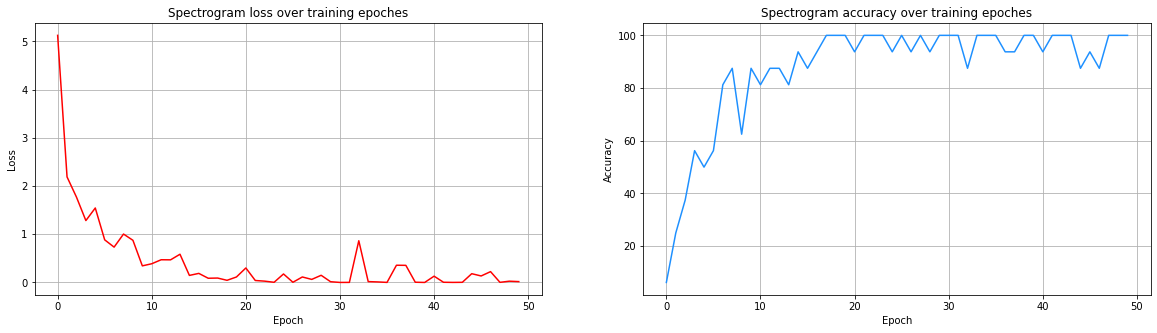

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].grid()
axs[0].plot(mel_epoch_plot, mel_loss_plot, color=colors['red'])
axs[0].set(xlabel='Epoch', ylabel='Loss')
axs[0].title.set_text('Spectrogram loss over training epoches')

axs[1].grid()
axs[1].plot(mel_epoch_plot, mel_accuracy_plot, color=colors['dodgerblue'])
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1].title.set_text('Spectrogram accuracy over training epoches')

In [41]:
model.eval()

MusicCNN(
  (_convblocks): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

Accuracy of the network on the test data: 82 %


## Chromagram

In [43]:
chroma = []
genre_new = []
N_FFT = 512
HOP_LEN = 256
num_div = 8

In [44]:
for idx, wav in enumerate(music_dataset):
    if wav.endswith('.wav'):
        y, sfr = librosa.load(wav)
        div = np.split(y[:660000], num_div)
        for chunck in div:
            chromagram = librosa.feature.chroma_stft(y=chunck, sr=sfr, hop_length=HOP_LEN, n_fft=N_FFT)
            chromagram_dB = librosa.power_to_db(chromagram, ref=np.max)
            chroma.append(chromagram_dB)
            genre_new.append(genre_target[idx])

In [45]:
genre_id = [genre_dict[item] for item in genre_new]

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mel_spec, genre_id, test_size=0.2, random_state=42)

In [47]:
BATCH_SIZE = 16

torch_X_train = torch.unsqueeze(torch.cuda.FloatTensor(X_train), 1)
torch_y_train = torch.cuda.LongTensor(y_train)

torch_X_test = torch.unsqueeze(torch.cuda.FloatTensor(X_test), 1)
torch_y_test = torch.cuda.LongTensor(y_test)

# Pytorch train and test data sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


In [52]:
model = MusicCNN()
model.cuda()
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
chroma_loss_plot = []
chroma_accuracy_plot = []
chroma_epoch_plot = []

In [54]:
EPOCHS = 50
model.train()
for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == var_y_batch).sum()
        #print(correct)
        if batch_idx % 480 == 0:
            print('Epoch : {}\t Loss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
            chroma_epoch_plot.append(epoch)
            chroma_loss_plot.append(loss.data)
            chroma_accuracy_plot.append(float(correct*100) / float(BATCH_SIZE*(batch_idx+1)))

Epoch : 0	 Loss: 5.727234	 Accuracy:6.250%
Epoch : 1	 Loss: 2.324697	 Accuracy:12.500%
Epoch : 2	 Loss: 1.337258	 Accuracy:56.250%
Epoch : 3	 Loss: 1.057863	 Accuracy:75.000%
Epoch : 4	 Loss: 1.155136	 Accuracy:75.000%
Epoch : 5	 Loss: 0.989323	 Accuracy:50.000%
Epoch : 6	 Loss: 0.734728	 Accuracy:75.000%
Epoch : 7	 Loss: 0.655612	 Accuracy:75.000%
Epoch : 8	 Loss: 0.367879	 Accuracy:87.500%
Epoch : 9	 Loss: 0.384174	 Accuracy:87.500%
Epoch : 10	 Loss: 0.682889	 Accuracy:87.500%
Epoch : 11	 Loss: 0.542540	 Accuracy:81.250%
Epoch : 12	 Loss: 0.177692	 Accuracy:93.750%
Epoch : 13	 Loss: 0.518877	 Accuracy:87.500%
Epoch : 14	 Loss: 0.234532	 Accuracy:93.750%
Epoch : 15	 Loss: 0.490346	 Accuracy:75.000%
Epoch : 16	 Loss: 0.269706	 Accuracy:87.500%
Epoch : 17	 Loss: 0.266335	 Accuracy:93.750%
Epoch : 18	 Loss: 0.049784	 Accuracy:100.000%
Epoch : 19	 Loss: 0.115014	 Accuracy:100.000%
Epoch : 20	 Loss: 0.070585	 Accuracy:100.000%
Epoch : 21	 Loss: 0.033334	 Accuracy:100.000%
Epoch : 22	 Loss:

In [55]:
torch.save(model.state_dict(),'/content/drive/My Drive/Colab Notebooks/Music Informatics/2D_CNN_Librosa_chromagram_all_samples.pth')

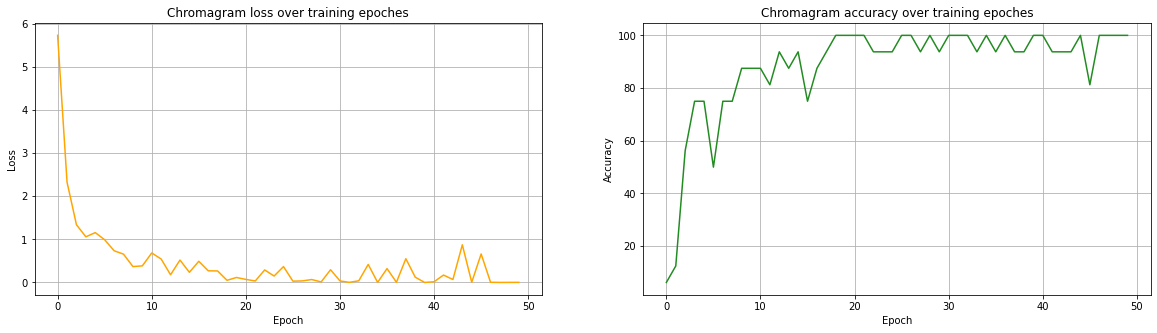

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].grid()
axs[0].plot(chroma_epoch_plot, chroma_loss_plot, color=colors['orange'])
axs[0].set(xlabel='Epoch', ylabel='Loss')
axs[0].title.set_text('Chromagram loss over training epoches')

axs[1].grid()
axs[1].plot(chroma_epoch_plot, chroma_accuracy_plot, color=colors['forestgreen'])
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1].title.set_text('Chromagram accuracy over training epoches')

In [57]:
model.eval()

MusicCNN(
  (_convblocks): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [58]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

Accuracy of the network on the test data: 82 %


## Melspectrogram vs Chromagram

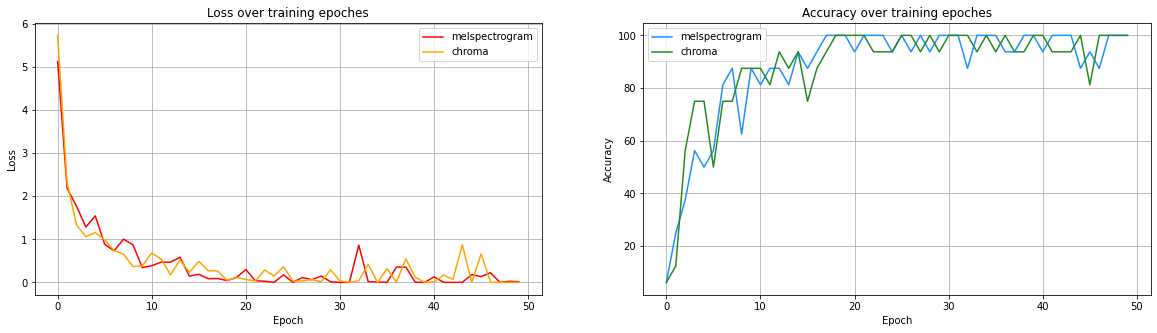

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].grid()
axs[0].plot(mel_epoch_plot, mel_loss_plot, color=colors['red'], label='melspectrogram')
axs[0].plot(chroma_epoch_plot, chroma_loss_plot, color=colors['orange'], label='chroma')
axs[0].set(xlabel='Epoch', ylabel='Loss')
axs[0].title.set_text('Loss over training epoches')
axs[0].legend(loc='best')

axs[1].grid()
axs[1].plot(mel_epoch_plot, mel_accuracy_plot, color=colors['dodgerblue'], label='melspectrogram')
axs[1].plot(chroma_epoch_plot, chroma_accuracy_plot, color=colors['forestgreen'], label='chroma')
axs[1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1].title.set_text('Accuracy over training epoches')
axs[1].legend(loc='best')